#MGT1062 BIG DATA COMPUTING FOR BUSINESS ANALYTICS
##LAB FAT
### HOMADHITYA J P[21MIA1096]

#Q1: LINEAR REGRESSION

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Load dataset
file_path = "employee.csv"  # Update this path to your dataset file
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 1: Remove rows with null values
df = df.na.drop()

# Step 2: Take input for independent and dependent columns from the user
independent_var = input("Enter the name of the independent variable (numeric column): ")
dependent_var = input("Enter the name of the dependent variable (numeric column): ")

# Convert columns to numeric if they are not already
for col_name in [independent_var, dependent_var]:
    if df.schema[col_name].dataType != DoubleType():
        df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Verify the columns were successfully cast to DoubleType
df.select(independent_var, dependent_var).printSchema()

# Step 3: Prepare the data for Linear Regression
assembler = VectorAssembler(inputCols=[independent_var], outputCol="features")
data = assembler.transform(df).select("features", dependent_var)

# Step 4: Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Step 5: Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=dependent_var)
lr_model = lr.fit(train_data)

# Step 6: Display the regression equation
intercept = lr_model.intercept
slope = lr_model.coefficients[0]
print(f"The regression equation is: {dependent_var} = {intercept} + ({slope} * {independent_var})")

# Step 7: Make predictions on the test data
predictions = lr_model.transform(test_data)

# Show a few actual and predicted values
print("\nActual vs Predicted Values:")
predictions.select(dependent_var, "prediction").show(10)

# Step 8: Print evaluation metrics
evaluator = RegressionEvaluator(labelCol=dependent_var, predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("\nRegression Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Stop Spark session
spark.stop()


Enter the name of the independent variable (numeric column): HourlyRate
Enter the name of the dependent variable (numeric column): MonthlyIncome
root
 |-- HourlyRate: double (nullable = true)
 |-- MonthlyIncome: double (nullable = true)

The regression equation is: MonthlyIncome = 6492.923180709714 + (0.5393222280804005 * HourlyRate)

Actual vs Predicted Values:
+-------------+-----------------+
|MonthlyIncome|       prediction|
+-------------+-----------------+
|       2859.0|6509.102847552126|
|       4014.0|6509.102847552126|
|       2783.0|6509.642169780206|
|       4869.0|6509.642169780206|
|       6893.0|6509.642169780206|
|       8837.0|6509.642169780206|
|       9525.0|6509.642169780206|
|       2695.0|6510.181492008287|
|       5660.0|6510.181492008287|
|       6029.0|6510.181492008287|
+-------------+-----------------+
only showing top 10 rows


Regression Metrics:
Root Mean Squared Error (RMSE): 4545.31771686234
Mean Absolute Error (MAE): 3506.2133344668596
R-squared (R2): -

#Q2: DECISION TREE

In [2]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import graphviz
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from google.colab import files
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("DecisionTreeExample").getOrCreate()

# Load your dataset (replace with your actual dataset path)
file_path = 'Breast_Cancer.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Remove extra spaces in column names
df = df.select([col(c).alias(c.strip()) for c in df.columns])

# Convert categorical columns to string or numerical as needed
categorical_columns = ['Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage', 'differentiate',
                       'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status']
# Remove extra spaces from categorical column names if they exist
df = df.select([col(c).alias(c.strip()) for c in df.columns])

# Handle 'T Stage' column with timestamp data type
df = df.withColumn("T Stage", col("T Stage").cast("string"))

# Step 1: Convert categorical columns to numerical using StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_onehot") for col in categorical_columns]

# Step 2: Assemble all features
numeric_columns = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive']  # Example numerical columns
assembler = VectorAssembler(inputCols=[col + "_onehot" for col in categorical_columns] + numeric_columns, outputCol="features")

# Step 3: Build a pipeline for preprocessing
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(df)
assembled_data = pipeline_model.transform(df)

# Step 4: Split the data into training and testing sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)

# Step 5: Train a Decision Tree Regressor (for regression task)
target_variable = 'Survival Months'  # Example target variable
dt = DecisionTreeRegressor(labelCol=target_variable, featuresCol="features")

# Step 6: Train the model
dt_model = dt.fit(train_data)

# Step 7: Evaluate the model
predictions = dt_model.transform(test_data)

# Regression Metrics (RMSE, MSE, MAE, MAPE, R^2)
evaluator = RegressionEvaluator(labelCol=target_variable, predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

# Step 8: Export decision tree as a textual representation
# Use the toDebugString() method for a textual representation
# Access the textual representation of the decision tree using the `toDebugString` attribute
tree_text = dt_model.toDebugString

# Print the textual representation of the decision tree
print("Decision Tree Structure:")
print(tree_text)



# Optional: Save the metrics to a file
metrics_file = "metrics.txt"
with open(metrics_file, 'w') as f:
    f.write(f"RMSE: {rmse}\n")
    f.write(f"MSE: {mse}\n")
    f.write(f"MAE: {mae}\n")
    f.write(f"R^2: {r2}\n")

files.download(metrics_file)


RMSE: 23.505821474127764
MSE: 552.5236431735659
MAE: 18.71595463901342
R^2: -0.05007048999412822
Decision Tree Structure:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_e59876879331, depth=5, numNodes=63, numFeatures=28
  If (feature 14 in {1.0})
   If (feature 22 in {0.0})
    If (feature 25 <= 32.5)
     If (feature 26 <= 22.5)
      If (feature 25 <= 29.5)
       Predict: 37.23076923076923
      Else (feature 25 > 29.5)
       Predict: 100.5
     Else (feature 26 > 22.5)
      If (feature 26 <= 26.5)
       Predict: 101.0
      Else (feature 26 > 26.5)
       Predict: 60.5
    Else (feature 25 > 32.5)
     If (feature 26 <= 16.5)
      If (feature 24 <= 49.5)
       Predict: 73.5
      Else (feature 24 > 49.5)
       Predict: 35.75
     Else (feature 26 > 16.5)
      If (feature 26 <= 28.5)
       Predict: 20.384615384615383
      Else (feature 26 > 28.5)
       Predict: 45.666666666666664
   Else (feature 22 not in {0.0})
    If (feature 27 <= 27.5)
     If (feature 26 <= 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

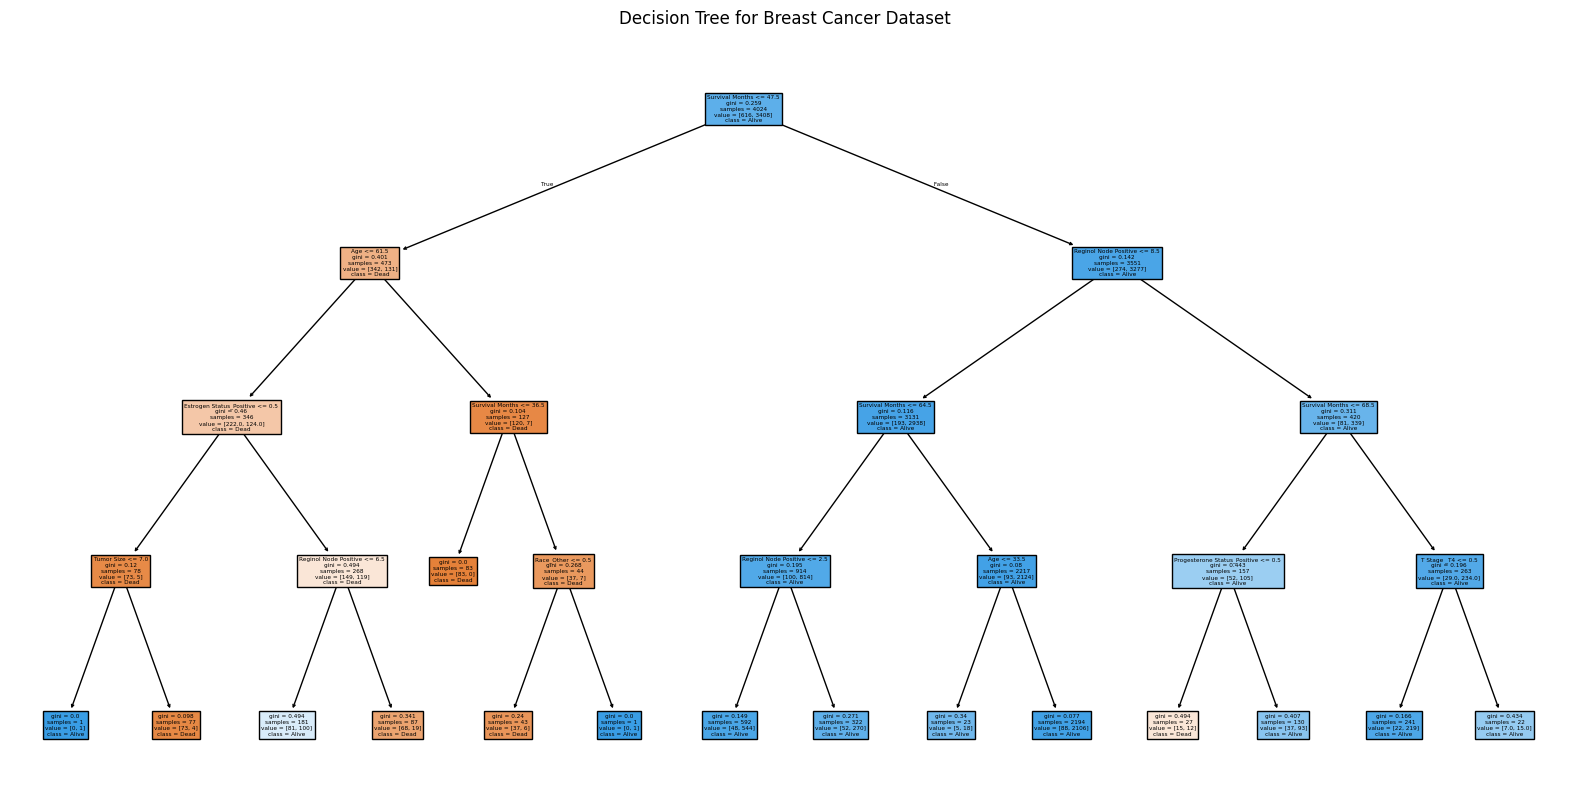

In [3]:
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd

# Load dataset into pandas for visualization
df = pd.read_csv("Breast_Cancer.csv")

# Prepare data
categorical_cols = ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
                    'differentiate', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

X = df_encoded.drop(columns=['Status_Alive', 'Status_Dead'])  # Adjust the target encoding
y = df_encoded['Status_Alive']

# Train a scikit-learn Decision Tree
dt_classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_classifier.fit(X, y)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=["Dead", "Alive"], filled=True)
plt.title("Decision Tree for Breast Cancer Dataset")
plt.show()


#Q3: PATH ANALYTICS
##A) SHORTEST PATH

Enter the path to the CSV file: indiancity.csv
Enter the origin city: Chennai
Enter the destination city: Vishakhapatnam
Shortest path from Chennai to Vishakhapatnam: ['Chennai', 'Hyderabad', 'Vishakhapatnam']
Total distance: 1245 km
Number of nodes in the network: 20
Number of edges in the network: 51


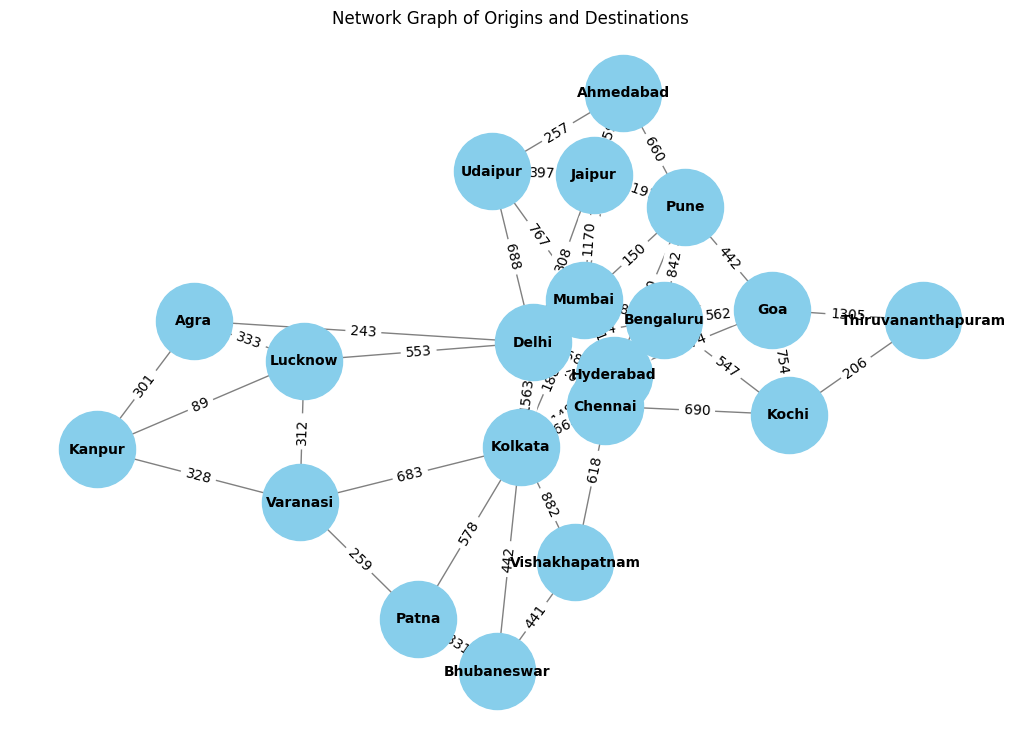


Node degrees (connections to other nodes):
Agra: 3 connections
Delhi: 9 connections
Lucknow: 4 connections
Kanpur: 3 connections
Ahmedabad: 4 connections
Mumbai: 10 connections
Pune: 6 connections
Jaipur: 5 connections
Udaipur: 4 connections
Bengaluru: 7 connections
Hyderabad: 8 connections
Chennai: 6 connections
Goa: 6 connections
Bhubaneswar: 3 connections
Kolkata: 8 connections
Vishakhapatnam: 3 connections
Patna: 3 connections
Kochi: 4 connections
Thiruvananthapuram: 2 connections
Varanasi: 4 connections

List of edges and distances:
From Agra to Delhi with distance 243 km
From Agra to Lucknow with distance 333 km
From Agra to Kanpur with distance 301 km
From Delhi to Jaipur with distance 308 km
From Delhi to Lucknow with distance 553 km
From Delhi to Chennai with distance 2208 km
From Delhi to Bengaluru with distance 2174 km
From Delhi to Mumbai with distance 1453 km
From Delhi to Hyderabad with distance 1583 km
From Delhi to Kolkata with distance 1563 km
From Delhi to Udaipur wi

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Read the CSV file using pandas
file_path = input("Enter the path to the CSV file: ")
df = pd.read_csv(file_path)

# Step 2: Create the graph using NetworkX
G = nx.Graph()

# Add edges to the graph with the corresponding distances
for _, row in df.iterrows():
    G.add_edge(row['Origin'], row['Destination'], weight=row['Distance'])

# Step 3: Shortest Path Calculation
# Input origin and destination
origin = input("Enter the origin city: ")
destination = input("Enter the destination city: ")

# Calculate shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=origin, target=destination, weight='weight')
shortest_distance = nx.shortest_path_length(G, source=origin, target=destination, weight='weight')

# Step 4: Print actual and predicted values (Shortest Path and Distance)
print(f"Shortest path from {origin} to {destination}: {shortest_path}")
print(f"Total distance: {shortest_distance} km")

# Step 5: Metrics
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes in the network: {num_nodes}")
print(f"Number of edges in the network: {num_edges}")

# Step 6: Network Graph Visualization
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # Positioning nodes using spring layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# Add edge labels (distances)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Network Graph of Origins and Destinations")
plt.show()

# Step 7: Additional Metrics: Degree of nodes (how many edges are connected to each node)
node_degrees = G.degree()
print("\nNode degrees (connections to other nodes):")
for node, degree in node_degrees:
    print(f"{node}: {degree} connections")

# Step 8: Additional: Display the list of edges and distances
print("\nList of edges and distances:")
for u, v, weight in G.edges(data=True):
    print(f"From {u} to {v} with distance {weight['weight']} km")


##B) MINIMAL SPANNING TREE

Enter the path to the CSV file: indiancity.csv
Edges in the Minimum Spanning Tree:
From Agra to Delhi with weight 243
From Agra to Kanpur with weight 301
From Delhi to Jaipur with weight 308
From Lucknow to Kanpur with weight 89
From Lucknow to Varanasi with weight 312
From Ahmedabad to Udaipur with weight 257
From Ahmedabad to Mumbai with weight 526
From Mumbai to Pune with weight 150
From Pune to Goa with weight 442
From Pune to Hyderabad with weight 560
From Jaipur to Udaipur with weight 397
From Bengaluru to Chennai with weight 345
From Bengaluru to Kochi with weight 547
From Bengaluru to Goa with weight 562
From Bhubaneswar to Vishakhapatnam with weight 441
From Bhubaneswar to Kolkata with weight 442
From Kolkata to Patna with weight 578
From Patna to Varanasi with weight 259
From Kochi to Thiruvananthapuram with weight 206

Total weight (distance) of the Minimum Spanning Tree: 6965 km
Number of nodes in MST: 20
Number of edges in MST: 19


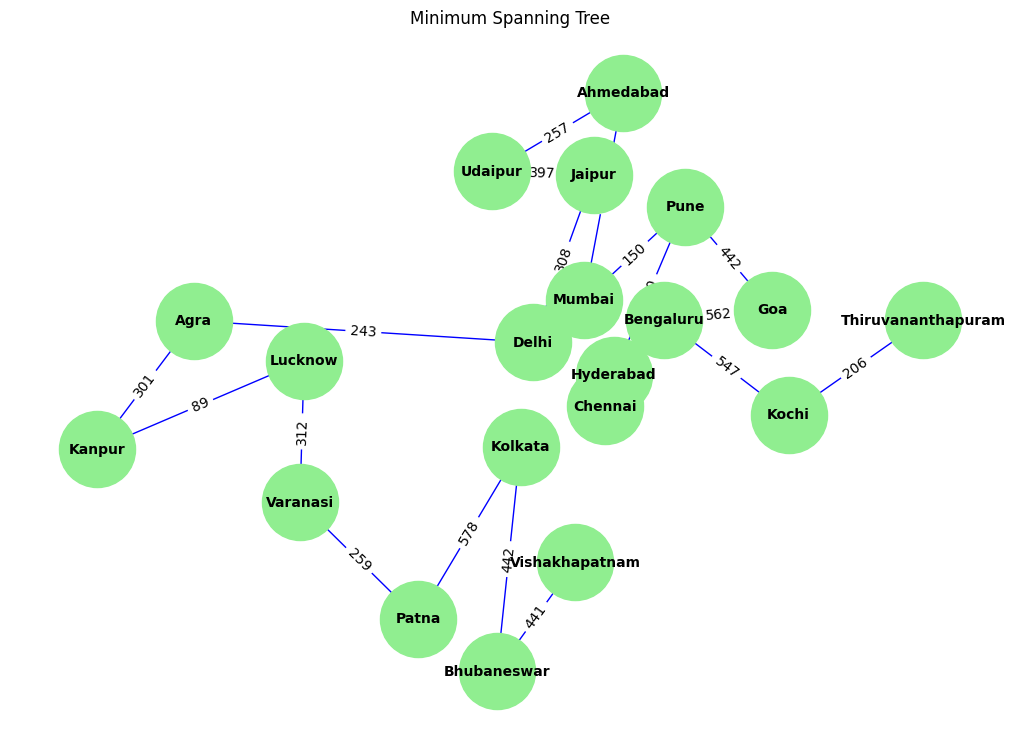

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Read the CSV file using pandas
file_path = input("Enter the path to the CSV file: ")
df = pd.read_csv(file_path)

# Step 2: Create the graph using NetworkX
G = nx.Graph()

# Add edges to the graph with the corresponding weights (distances)
for _, row in df.iterrows():
    G.add_edge(row['Origin'], row['Destination'], weight=row['Distance'])

# Step 3: Calculate Minimum Spanning Tree (MST) using Kruskal's algorithm
mst = nx.minimum_spanning_tree(G, weight='weight')

# Step 4: Display the MST
print("Edges in the Minimum Spanning Tree:")
for u, v, weight in mst.edges(data=True):
    print(f"From {u} to {v} with weight {weight['weight']}")

# Step 5: MST Metrics
mst_weight = sum(weight['weight'] for _, _, weight in mst.edges(data=True))
print(f"\nTotal weight (distance) of the Minimum Spanning Tree: {mst_weight} km")
print(f"Number of nodes in MST: {mst.number_of_nodes()}")
print(f"Number of edges in MST: {mst.number_of_edges()}")

# Step 6: MST Visualization
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # Positioning nodes using spring layout
nx.draw(mst, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='blue')

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(mst, 'weight')
nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels)

plt.title("Minimum Spanning Tree")
plt.show()


#Q4: COMMUNITY DETECTION
##A) TRIANGLE COUNT AND CLUSTER CO-EFFICIENT
##B) LOUVAIN MODULARITY

In [8]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.9 MB/s eta 0:00:00


Step 1: Generating synthetic data...
Generated synthetic social media data saved to social_media_data.csv

Step 2: Loading dataset...
Dataset loaded with 20 nodes and 77 edges!

Step 3: Detecting communities using Greedy Modularity...
Detected 3 communities!
Community 1: ['cassie73', 'delgadojohn', 'dgilbert', 'ericfisher', 'kevin65', 'mathewslisa', 'rochaoscar', 'vcollins']
Community 2: ['amorris', 'brich', 'cwong', 'jonathanreynolds', 'jose87', 'tammy91', 'toddthomas']
Community 3: ['amy61', 'mollywong', 'ricardowatson', 'williamsjasmine', 'ygriffith']

Step 4: Calculating metrics...

Community Detection Metrics:
Number of Communities (Greedy Modularity): 3
Modularity Score (Greedy Modularity): 0.1645

Triangle Count: 78
Average Triangle Count per Node: 3.9000

Average Clustering Coefficient: 0.4288

Step 5: Visualizing communities (Greedy Modularity)...


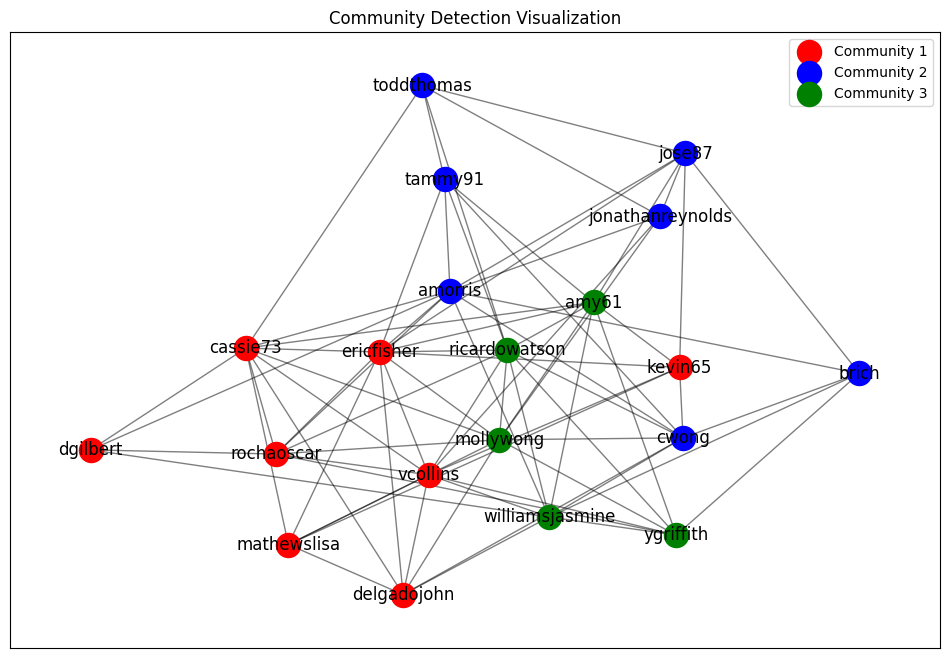


Step 6: Detecting communities using Louvain Modularity...
Detected 4 Louvain communities!
Louvain Community 1: ['cassie73', 'delgadojohn', 'ericfisher', 'kevin65', 'mathewslisa', 'mollywong', 'vcollins']
Louvain Community 2: ['amy61', 'brich', 'cwong', 'ricardowatson', 'tammy91', 'williamsjasmine', 'ygriffith']
Louvain Community 3: ['amorris', 'dgilbert', 'rochaoscar']
Louvain Community 4: ['jonathanreynolds', 'jose87', 'toddthomas']

Step 7: Visualizing Louvain communities...


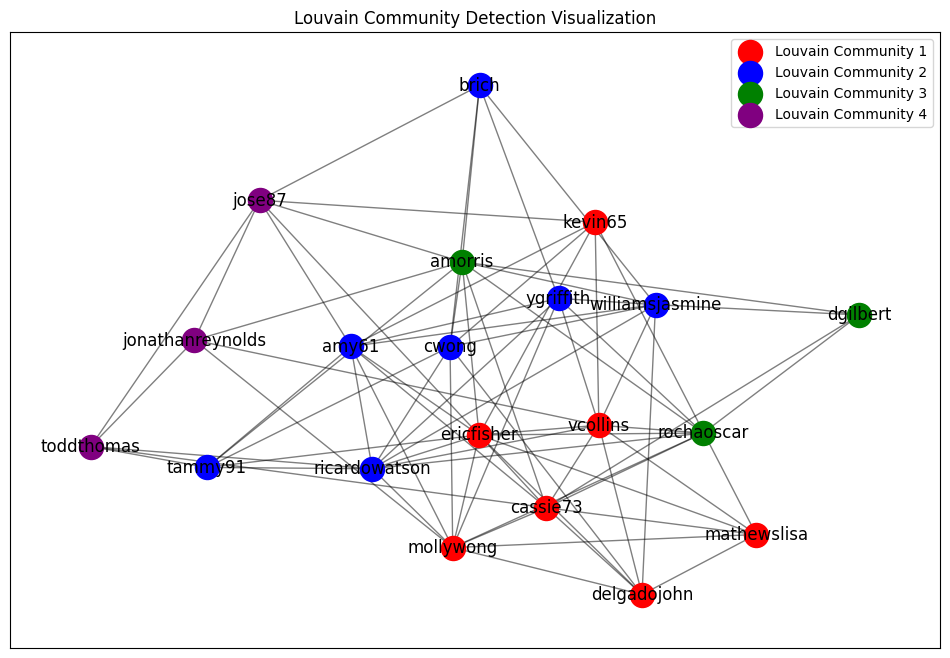

In [9]:
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities, modularity, louvain_communities
import faker

# Step 1: Generate a synthetic social media dataset
def generate_social_media_data(num_rows=100):
    fake = faker.Faker()  # Use Faker to generate random names
    user_ids = [fake.user_name() for _ in range(1, 21)]  # Generate 20 random user names
    connections = ["Friend", "Follower", "Interaction"]  # Connection types
    data = []

    for _ in range(num_rows):
        user1 = random.choice(user_ids)
        user2 = random.choice([uid for uid in user_ids if uid != user1])
        connection = random.choice(connections)
        data.append({"User ID": user1, "Connection": user2, "Type": connection})

    # Save to CSV
    df = pd.DataFrame(data)
    csv_file = "social_media_data.csv"
    df.to_csv(csv_file, index=False)
    print(f"Generated synthetic social media data saved to {csv_file}")
    return csv_file

# Step 2: Load dataset
def load_dataset(csv_file):
    data = pd.read_csv(csv_file)
    edges = [(row["User ID"], row["Connection"]) for _, row in data.iterrows()]
    G = nx.Graph()
    G.add_edges_from(edges)
    print(f"Dataset loaded with {len(G.nodes)} nodes and {len(G.edges)} edges!")
    return G

# Step 3: Perform community detection using Greedy Modularity
def detect_communities(G):
    communities = list(greedy_modularity_communities(G))
    return communities

# Step 4: Perform community detection using Louvain Method
def detect_louvain_communities(G):
    communities = list(louvain_communities(G))
    return communities

# Step 5: Calculate metrics - Triangle Count and Clustering Coefficient
def calculate_metrics(G, communities):
    # Modularity Score (using Greedy Modularity)
    modularity_score = modularity(G, communities)

    # Triangle Count
    triangle_count = nx.triangles(G)  # Dictionary of node -> triangle count
    total_triangles = sum(triangle_count.values()) // 3  # Each triangle is counted 3 times
    avg_triangle_count = total_triangles / len(G.nodes)

    # Clustering Coefficient
    clustering_coeff = nx.clustering(G)  # Dictionary of node -> clustering coefficient
    avg_clustering_coeff = sum(clustering_coeff.values()) / len(clustering_coeff)

    # Print metrics
    print("\nCommunity Detection Metrics:")
    print(f"Number of Communities (Greedy Modularity): {len(communities)}")
    print(f"Modularity Score (Greedy Modularity): {modularity_score:.4f}")
    print(f"\nTriangle Count: {total_triangles}")
    print(f"Average Triangle Count per Node: {avg_triangle_count:.4f}")
    print(f"\nAverage Clustering Coefficient: {avg_clustering_coeff:.4f}")

# Step 6: Visualize the network graph with communities
def visualize_communities(G, communities):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']

    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(
            G, pos, nodelist=community, node_color=colors[i % len(colors)], label=f"Community {i + 1}"
        )
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos)

    plt.title("Community Detection Visualization")
    plt.legend()
    plt.show()

# Step 7: Visualize the Louvain Community Structure
def visualize_louvain_communities(G, communities):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']

    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(
            G, pos, nodelist=community, node_color=colors[i % len(colors)], label=f"Louvain Community {i + 1}"
        )
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos)

    plt.title("Louvain Community Detection Visualization")
    plt.legend()
    plt.show()

# Main program
def main():
    print("Step 1: Generating synthetic data...")
    csv_file = generate_social_media_data()

    print("\nStep 2: Loading dataset...")
    G = load_dataset(csv_file)

    print("\nStep 3: Detecting communities using Greedy Modularity...")
    communities = detect_communities(G)
    print(f"Detected {len(communities)} communities!")
    for i, community in enumerate(communities):
        print(f"Community {i + 1}: {sorted(community)}")

    print("\nStep 4: Calculating metrics...")
    calculate_metrics(G, communities)

    print("\nStep 5: Visualizing communities (Greedy Modularity)...")
    visualize_communities(G, communities)

    print("\nStep 6: Detecting communities using Louvain Modularity...")
    louvain_communities_list = detect_louvain_communities(G)
    print(f"Detected {len(louvain_communities_list)} Louvain communities!")
    for i, community in enumerate(louvain_communities_list):
        print(f"Louvain Community {i + 1}: {sorted(community)}")

    print("\nStep 7: Visualizing Louvain communities...")
    visualize_louvain_communities(G, louvain_communities_list)

# Execute the program
main()


#Q5: CENTRALITY ANALYTICS
## A) BETWEEN CENTRALITY
## B) PAGERANK

Dataset saved as 'citation_network.csv'. You can download it.
Top 5 papers by Betweenness Centrality:
Paper: Trends on AI (46), Betweenness Centrality: 0.1177
Paper: Insights on Education (61), Betweenness Centrality: 0.0877
Paper: Trends on Education (54), Betweenness Centrality: 0.0802
Paper: Trends on Technology (21), Betweenness Centrality: 0.0781
Paper: Analysis on Energy (18), Betweenness Centrality: 0.0718

Top 5 papers by PageRank:
Paper: Trends on Education (54), PageRank: 0.0271
Paper: Trends on AI (46), PageRank: 0.0260
Paper: Study on Climate (95), PageRank: 0.0243
Paper: Analysis on AI (41), PageRank: 0.0231
Paper: Analysis on Energy (18), PageRank: 0.0226

Summary of Centrality Distribution:
Minimum Betweenness Centrality: 0.0000
Maximum Betweenness Centrality: 0.1177
Average Betweenness Centrality: 0.0297
Minimum PageRank: 0.0015
Maximum PageRank: 0.0271
Average PageRank: 0.0100


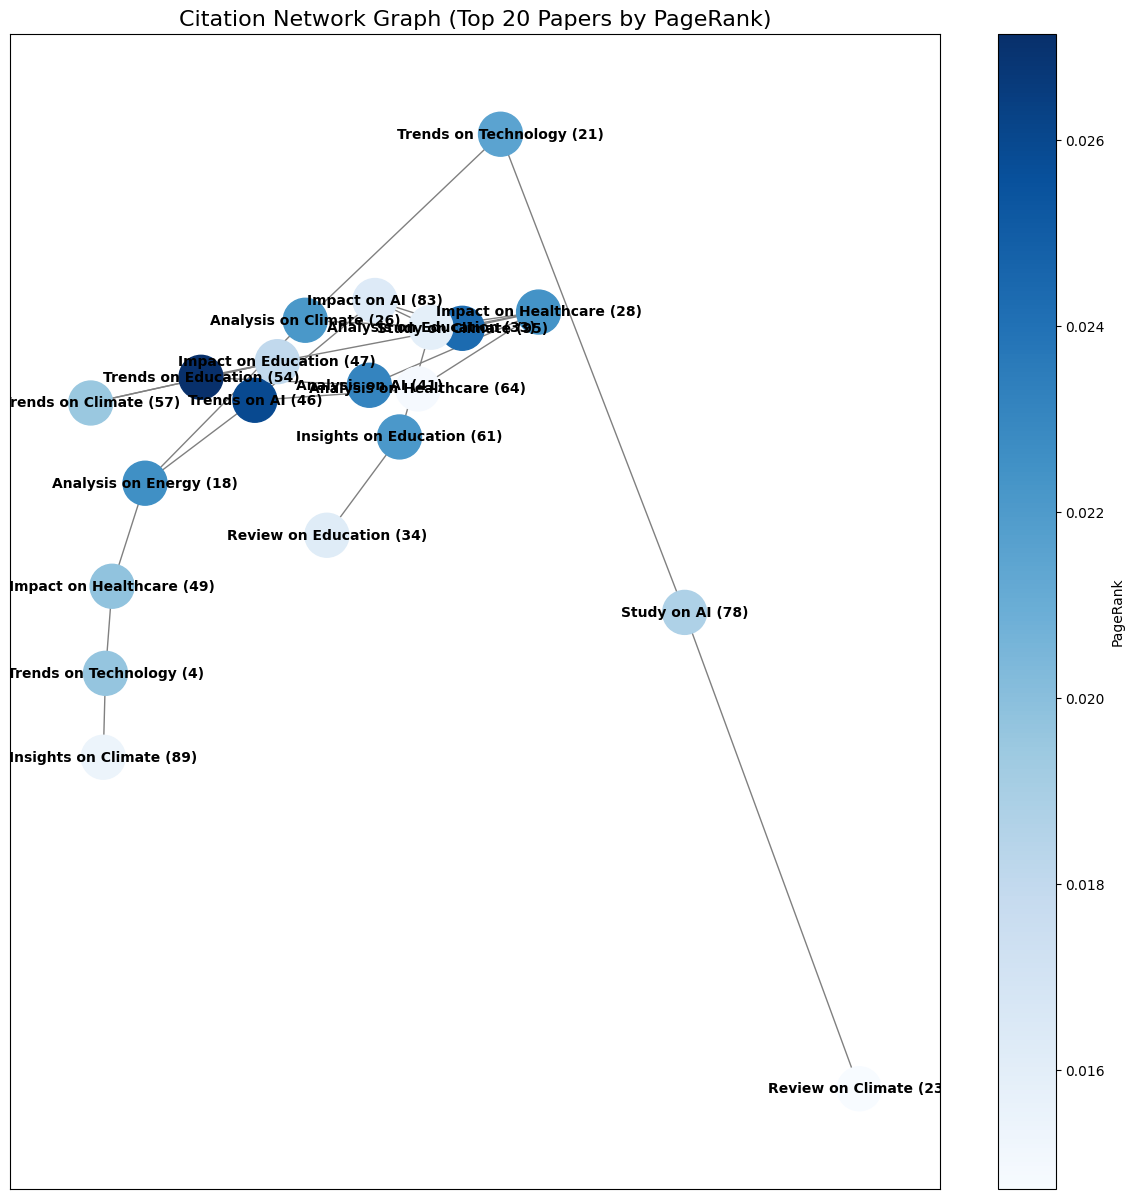

In [15]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Create a custom citation network with 100 nodes
num_papers = 100
papers = [
    f"{random.choice(['Impact', 'Trends', 'Analysis', 'Review', 'Study', 'Insights'])} "
    f"on {random.choice(['AI', 'Healthcare', 'Climate', 'Technology', 'Education', 'Energy'])} ({i+1})"
    for i in range(num_papers)
]

# Generate random citations (edges)
edges = []
for i in range(num_papers):
    num_citations = random.randint(1, 5)  # Each paper cites 1-5 other papers
    citations = random.sample(range(num_papers), num_citations)
    for citation in citations:
        if citation != i:  # Avoid self-citations
            edges.append((papers[i], papers[citation]))

# Save dataset to a CSV file
edges_df = pd.DataFrame(edges, columns=["Source Paper", "Cited Paper"])
edges_df.to_csv("citation_network.csv", index=False)
print("Dataset saved as 'citation_network.csv'. You can download it.")

# Create a directed graph for the citation network
G = nx.DiGraph()
G.add_edges_from(edges)

# Step 2: Calculate Centrality Metrics
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# PageRank
pagerank_centrality = nx.pagerank(G)

# Step 3: Get Top Papers
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Print Top 5 Papers by Betweenness Centrality
print("Top 5 papers by Betweenness Centrality:")
for paper, score in top_5_betweenness:
    print(f"Paper: {paper}, Betweenness Centrality: {score:.4f}")

# Print Top 5 Papers by PageRank
print("\nTop 5 papers by PageRank:")
for paper, score in top_5_pagerank:
    print(f"Paper: {paper}, PageRank: {score:.4f}")

# Summary of Centrality Distribution
print("\nSummary of Centrality Distribution:")
print(f"Minimum Betweenness Centrality: {min(betweenness_centrality.values()):.4f}")
print(f"Maximum Betweenness Centrality: {max(betweenness_centrality.values()):.4f}")
print(f"Average Betweenness Centrality: {sum(betweenness_centrality.values()) / len(betweenness_centrality):.4f}")
print(f"Minimum PageRank: {min(pagerank_centrality.values()):.4f}")
print(f"Maximum PageRank: {max(pagerank_centrality.values()):.4f}")
print(f"Average PageRank: {sum(pagerank_centrality.values()) / len(pagerank_centrality):.4f}")

# Step 4: Visualization of Citation Network
# Subgraph for Top 20 Papers by PageRank
top_20_papers = [paper for paper, _ in sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:20]]
subgraph = G.subgraph(top_20_papers)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(subgraph)  # Position nodes using spring layout
node_colors = [pagerank_centrality[paper] for paper in subgraph.nodes]  # Node color based on PageRank

# Draw the graph
nodes = nx.draw_networkx_nodes(
    subgraph, pos, node_size=1000, node_color=node_colors, cmap=plt.cm.Blues
)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

# Add a colorbar
plt.colorbar(nodes, label='PageRank')

plt.title("Citation Network Graph (Top 20 Papers by PageRank)", fontsize=16)
plt.show()
